## Importing necessary libraries

In [5]:
%%capture
!pip install seaborn

In [8]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D, AveragePooling2D, Concatenate, AveragePooling2D, Dropout, Input, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [6]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [7]:
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [14]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

## Data Analysis

In [15]:
# printing the disease names
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [30]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [31]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [32]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [33]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [34]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


In [35]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


## Data Preparation for training

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=128
)

Found 70295 files belonging to 38 classes.


In [19]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

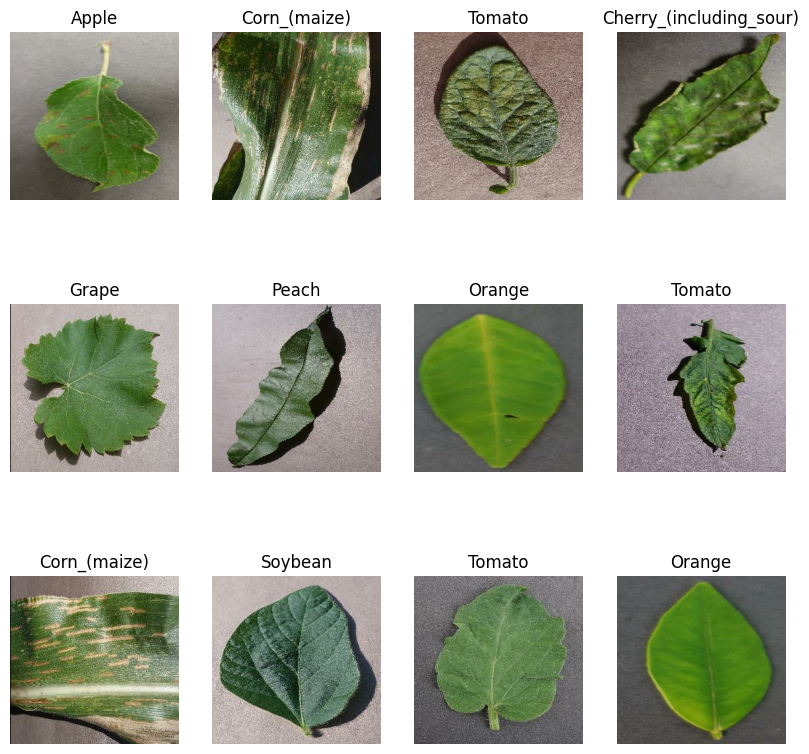

In [38]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]].split("/")[-1].split("___")[0])
        plt.axis("off")

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


### Cache, Shuffle, and Prefetch the Dataset

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [41]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 38

In [43]:
# with tpu_strategy.scope():

#     model = models.Sequential([
#         # Layer for Resizing and Normalization
#         resize_and_rescale,
#         # Input layer
#         layers.Conv2D(16, kernel_size=(3, 3),activation='relu', padding="same",
#                 kernel_initializer='he_normal',input_shape=input_shape),

#         # Add convolution layers to perform Feature extraction
#         layers.Conv2D(64,kernel_size=(3, 3), activation='relu'),
#         layers.Dropout(0.2),
#         layers.Conv2D(64,kernel_size=5, padding='same',activation='relu'),
#         layers.MaxPooling2D((2, 2)),

#         layers.Conv2D(128,kernel_size=(3, 3), activation='relu'),
#         layers.Dropout(0.2),
#         layers.Conv2D(128,kernel_size=5,padding='same',activation='relu'),
#         layers.MaxPooling2D((2, 2)),

#         layers.Conv2D(256,kernel_size=(3, 3),  activation='relu'),
#         layers.Dropout(0.3),
#         layers.Conv2D(256,kernel_size=5,padding='same',activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Conv2D(512,kernel_size=(3, 3),  activation='relu'),
#         layers.Dropout(0.3),
#         layers.Conv2D(512,kernel_size=5,padding='same',activation='relu'),
#         layers.MaxPooling2D((2, 2)),

#         #Add flatten layer to convert the 3D outputs to 1D
#         layers.Flatten(),

#         # Add dence layers to perform classification
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(0.4),

#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.6),

#         layers.Dense(n_classes, activation='softmax'),
#     ])
#     model.build(input_shape=input_shape)

**Note:** this custom cnn model is not performing well with this data set.(accuracy is too low)

## Create GoogleNet Model

In [44]:
def inceptionnet(x,filters):
    
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    

    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    
    #(5x5) layer
    
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    
    
    
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    
    
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])
    
    
def helperfunction(x,name=None):
    
    layer=AveragePooling2D(pool_size=(5,5),strides=3,padding="valid")(x)
    
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Flatten()(layer)
    
    layer=Dense(units=255,activation="relu")(layer)
    
    layer=Dropout(0.4)(layer)
    layer=Dense(units=38,activation="softmax",name=name)(layer)
    
    return layer
    
       
def googlenet():
    
    #taking layer input
    inputlayer=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    layer=BatchNormalization()(layer)
    
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    
    #layer_6
    
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=n_classes,activation="softmax",name="final_layer_2")(layer)
    
    
    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    
    return model

In [45]:
with tpu_strategy.scope():
    model=googlenet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_59 (Conv2D)             (None, 256, 256, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 128, 128, 64  0          ['conv2d_59[0][0]']              
 )                              )                                                           

In [46]:
with tpu_strategy.scope():
    # Compile the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer="adam", 
        metrics=["accuracy"],
        steps_per_execution=32
    )

In [47]:
# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Reduce the learning rate when a model has stopped improving.
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [48]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=valid_ds,
                    callbacks=[early_stopping, learning_rate_reduction, cp_callback])

Epoch 1/30
550/550 [==============================] - ETA: 0s - loss: 5.7238 - final_layer_2_loss: 2.3806 - final_layer_0_loss: 1.6616 - final_layer_1_loss: 1.6817 - final_layer_2_accuracy: 0.5761 - final_layer_0_accuracy: 0.5225 - final_layer_1_accuracy: 0.5148
Epoch 1: saving model to /kaggle/working/cp.ckpt
550/550 [==============================] - 228s 414ms/step - loss: 5.7238 - final_layer_2_loss: 2.3806 - final_layer_0_loss: 1.6616 - final_layer_1_loss: 1.6817 - final_layer_2_accuracy: 0.5761 - final_layer_0_accuracy: 0.5225 - final_layer_1_accuracy: 0.5148 - val_loss: 4.4578 - val_final_layer_2_loss: 1.5369 - val_final_layer_0_loss: 1.3748 - val_final_layer_1_loss: 1.5461 - val_final_layer_2_accuracy: 0.5599 - val_final_layer_0_accuracy: 0.5888 - val_final_layer_1_accuracy: 0.5447 - lr: 0.0010
Epoch 2/30
550/550 [==============================] - ETA: 0s - loss: 1.6314 - final_layer_2_loss: 0.4376 - final_layer_0_loss: 0.6119 - final_layer_1_loss: 0.5819 - final_layer_2_accura

## Save & Load Model

In [49]:
# Save the model
tf.keras.models.save_model(model,'/kaggle/working/plant-leaf-classifier.hdf5')


In [ ]:
model.save('/kaggle/working/v1')

In [9]:
# Load the model
loaded_model = tf.keras.models.load_model('/kaggle/input/temp-models/plant-leaves-disease-classifier.hdf5')

In [7]:
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_generator=testdata_generator.flow_from_directory(valid_dir,batch_size=128,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=False )

NameError: name 'valid_dir' is not defined

## Model Prediction

In [ ]:
pred, _, _=model.predict(test_data_generator)
final_predict = np.argmax(pred,axis=1)
true_data=test_data_generator.classes
print(final_predict, true_data)

## Accuracy Score

In [65]:
acc_score = accuracy_score(true_data,final_predict)
acc_score

0.026804006373776463

## Confusion Matrix

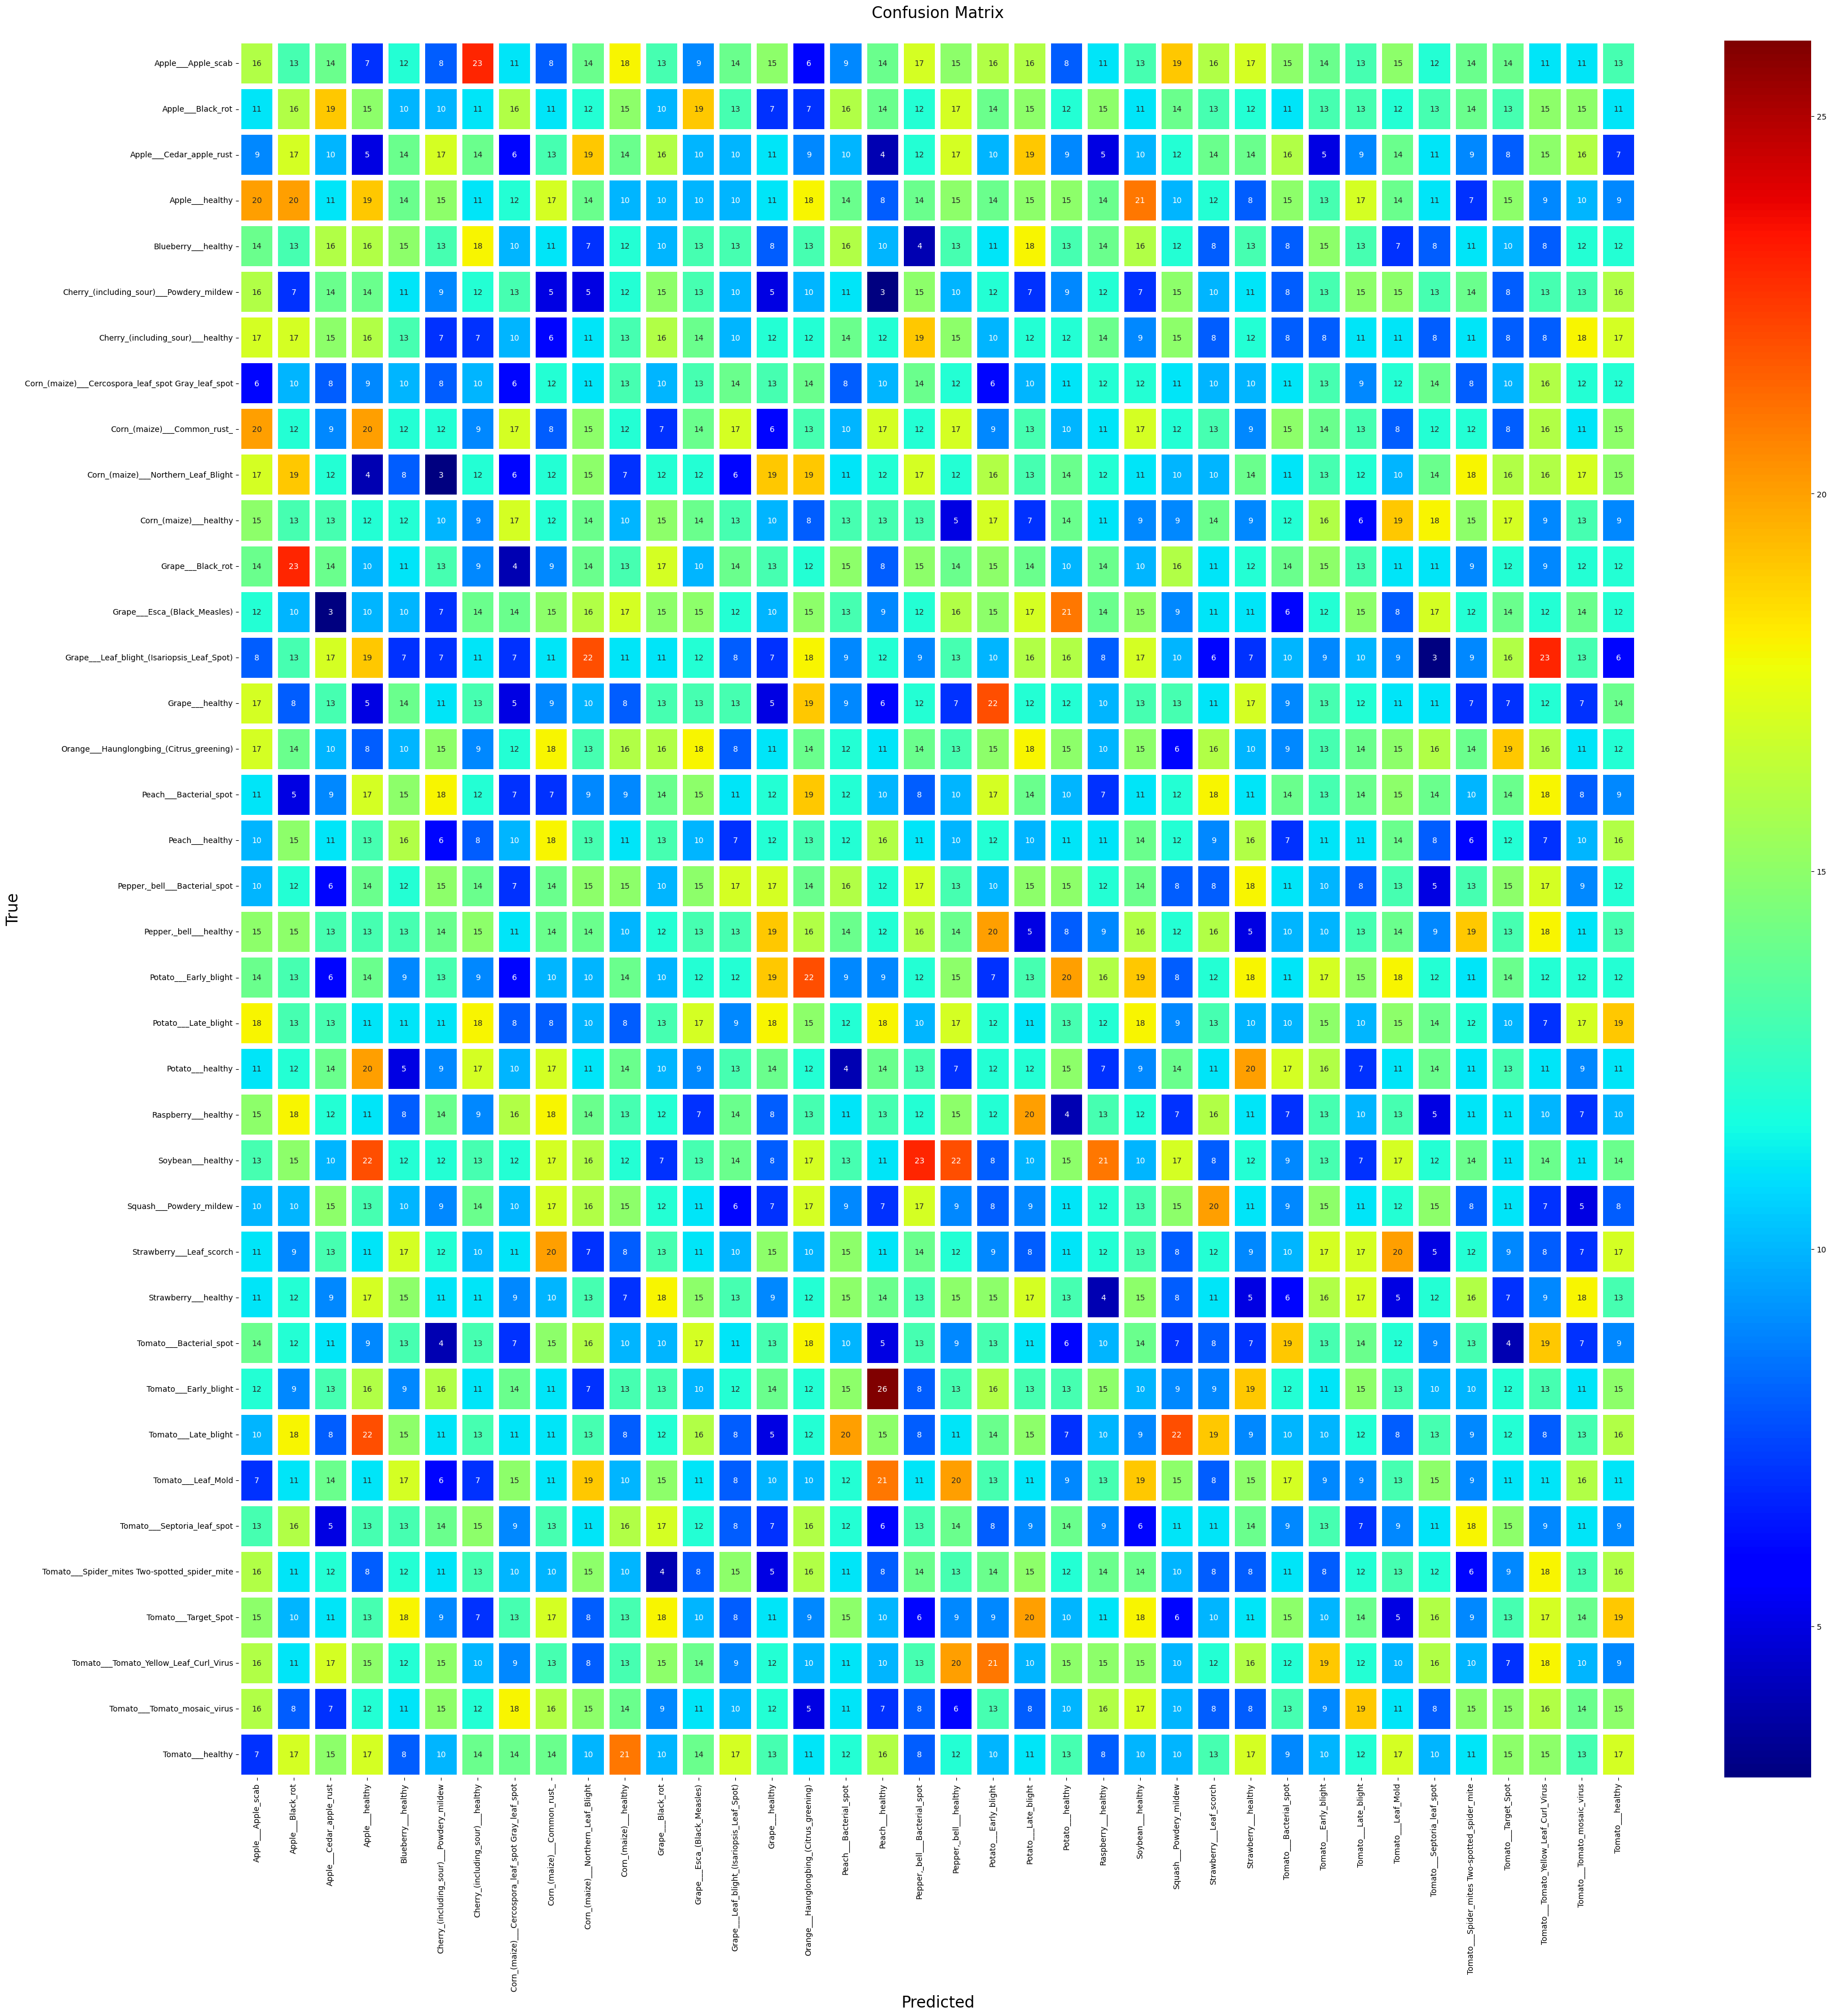

In [70]:
plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=class_names,
            yticklabels=class_names,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

## Classification Report

In [72]:
print(classification_report(true_data, final_predict,target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.03      0.03      0.03       504
                                 Apple___Black_rot       0.03      0.03      0.03       497
                          Apple___Cedar_apple_rust       0.02      0.02      0.02       440
                                   Apple___healthy       0.04      0.04      0.04       502
                               Blueberry___healthy       0.03      0.03      0.03       454
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       421
                 Cherry_(including_sour)___healthy       0.02      0.02      0.02       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.01      0.01      0.01       410
                       Corn_(maize)___Common_rust_       0.02      0.02      0.02       477
               Corn_(maize)___Northern_Leaf_Blight       0.03      0.03      0.

## Inferencing

In [ ]:
class_name = list(test_data_generator.class_indices.keys())

plt.figure(figsize=(30,30))
number_images=(5,5)
for i in range(1,(number_images[0]*number_images[1])+1):
    plt.subplot(number_images[0],number_images[1],i)
    plt.axis("off")
    
    true_label = class_name[test_data_generator.classes[i]]
    predicted_label = class_name[final_predict[i]]
    
    color="darkgreen"
    if true_label != predicted_label:
        color="red"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.imshow(plt.imread(test_data_generator.filepaths[i]))
plt.show()

1/1 [==============================] - 0s 286ms/step
Predicted class: Tomato___Late_blight
Maximum probability: 0.9998440742492676


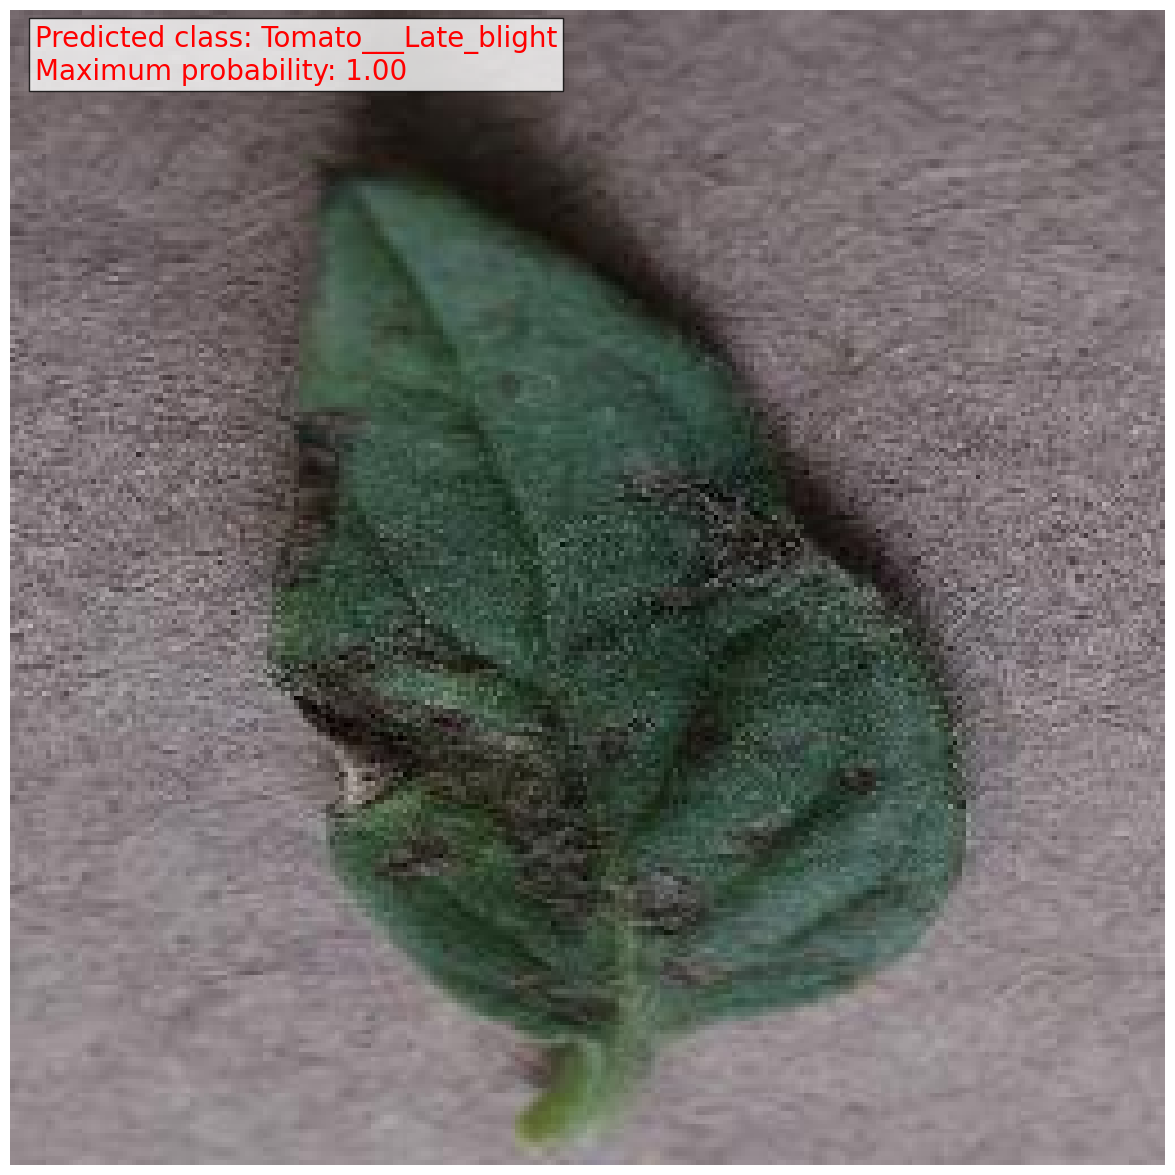

In [21]:
plt.figure(figsize=(15, 15))

img_path = "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG"

img = Image.open(img_path)
img = img.resize((256, 256))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)
probs = loaded_model.predict(img)[0]

# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = class_names[pred_class_prob]

max_prob = np.max(probs)
print(f'Predicted class: {pred_class_name}')
print(f'Maximum probability: {max_prob}')

# Display the image with the predicted class and probability
plt.imshow(img[0])
plt.axis('off')
plt.text(5, 15, f'Predicted class: {pred_class_name}\nMaximum probability: {max_prob:.2f}', fontsize=20, color='red', bbox=dict(facecolor='white', alpha=0.8))
plt.show()